# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

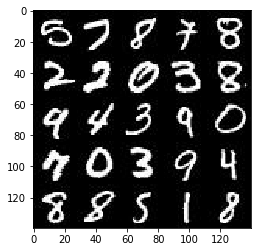

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

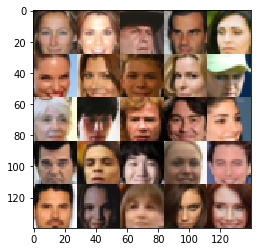

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #real_size = (image_width,image_height,image_channels)
    inp_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    inp_z=tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learn_rate=tf.placeholder(tf.float32,name='learning_rate')

    return inp_real,inp_z,learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse= not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # Optimize        
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real,input_z,lr=model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss,g_loss=model_loss(input_real,input_z,data_shape[-1])
    d_train_opt,g_train_opt=model_opt(d_loss,g_loss,lr,beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):                
                                
                # TODO: Train Model
                start_time = time.time()
                batch_images=batch_images*2
                steps+=1
                #sample random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g),
                      "... Time spent={:.4f}".format(time.time() - start_time))    

                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 100... Discriminator Loss: 1.1640... Generator Loss: 1.9704 ... Time spent=0.2366
Epoch 1/2 Step 200... Discriminator Loss: 1.1010... Generator Loss: 1.7246 ... Time spent=0.1763


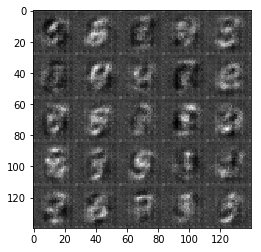

Epoch 1/2 Step 300... Discriminator Loss: 1.0748... Generator Loss: 1.9263 ... Time spent=0.1788
Epoch 1/2 Step 400... Discriminator Loss: 0.8183... Generator Loss: 1.1252 ... Time spent=0.1806


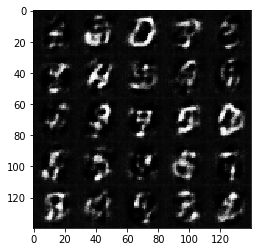

Epoch 1/2 Step 500... Discriminator Loss: 1.1156... Generator Loss: 0.6985 ... Time spent=0.1803
Epoch 1/2 Step 600... Discriminator Loss: 0.8908... Generator Loss: 1.3927 ... Time spent=0.1850


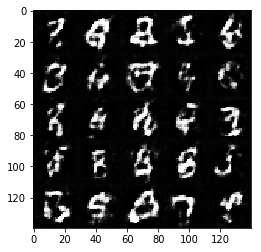

Epoch 2/2 Step 700... Discriminator Loss: 1.1182... Generator Loss: 2.0338 ... Time spent=0.1845
Epoch 2/2 Step 800... Discriminator Loss: 1.1184... Generator Loss: 0.6921 ... Time spent=0.1786


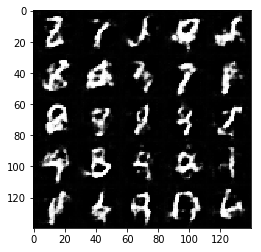

Epoch 2/2 Step 900... Discriminator Loss: 1.1113... Generator Loss: 1.5808 ... Time spent=0.1801
Epoch 2/2 Step 1000... Discriminator Loss: 0.9369... Generator Loss: 1.0275 ... Time spent=0.1750


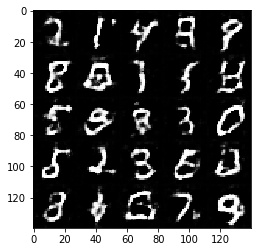

Epoch 2/2 Step 1100... Discriminator Loss: 1.2332... Generator Loss: 0.6079 ... Time spent=0.1820
Epoch 2/2 Step 1200... Discriminator Loss: 0.9746... Generator Loss: 0.9065 ... Time spent=0.1837


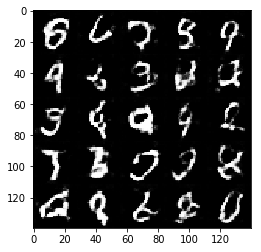

In [28]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10 Step 100... Discriminator Loss: 0.9478... Generator Loss: 1.7809 ... Time spent=0.2361
Epoch 1/10 Step 200... Discriminator Loss: 1.2325... Generator Loss: 0.9054 ... Time spent=0.1746


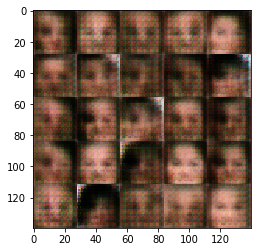

Epoch 1/10 Step 300... Discriminator Loss: 1.4755... Generator Loss: 2.4468 ... Time spent=0.1782
Epoch 1/10 Step 400... Discriminator Loss: 1.2518... Generator Loss: 0.6610 ... Time spent=0.1751


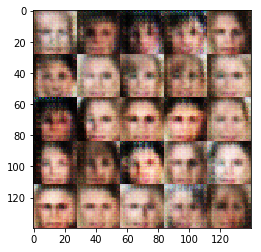

Epoch 1/10 Step 500... Discriminator Loss: 1.2918... Generator Loss: 0.8048 ... Time spent=0.1743
Epoch 1/10 Step 600... Discriminator Loss: 1.3924... Generator Loss: 0.7058 ... Time spent=0.1743


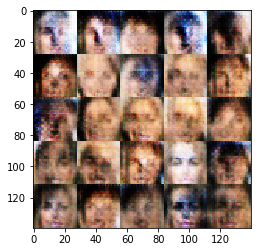

Epoch 1/10 Step 700... Discriminator Loss: 1.0981... Generator Loss: 0.8967 ... Time spent=0.1744
Epoch 1/10 Step 800... Discriminator Loss: 1.1509... Generator Loss: 0.7770 ... Time spent=0.1753


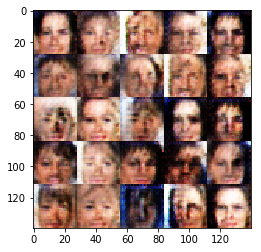

Epoch 1/10 Step 900... Discriminator Loss: 1.1777... Generator Loss: 1.2224 ... Time spent=0.1744
Epoch 1/10 Step 1000... Discriminator Loss: 1.5110... Generator Loss: 1.5311 ... Time spent=0.1746


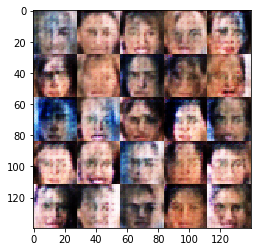

Epoch 1/10 Step 1100... Discriminator Loss: 1.2283... Generator Loss: 0.9134 ... Time spent=0.1760
Epoch 1/10 Step 1200... Discriminator Loss: 1.3388... Generator Loss: 0.5857 ... Time spent=0.1748


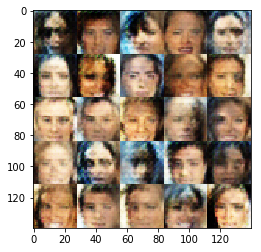

Epoch 1/10 Step 1300... Discriminator Loss: 0.9963... Generator Loss: 1.3205 ... Time spent=0.1753
Epoch 1/10 Step 1400... Discriminator Loss: 1.0951... Generator Loss: 0.9595 ... Time spent=0.1746


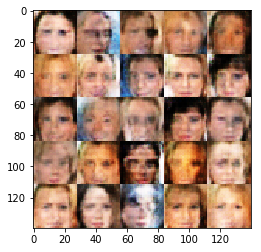

Epoch 1/10 Step 1500... Discriminator Loss: 1.4527... Generator Loss: 0.4957 ... Time spent=0.1757
Epoch 1/10 Step 1600... Discriminator Loss: 1.4213... Generator Loss: 1.4950 ... Time spent=0.1767


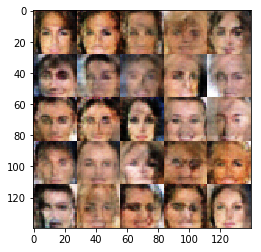

Epoch 1/10 Step 1700... Discriminator Loss: 1.2120... Generator Loss: 1.2799 ... Time spent=0.1767
Epoch 1/10 Step 1800... Discriminator Loss: 1.0915... Generator Loss: 1.2470 ... Time spent=0.1757


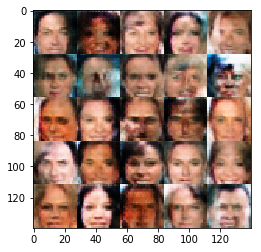

Epoch 1/10 Step 1900... Discriminator Loss: 1.1286... Generator Loss: 1.5331 ... Time spent=0.1762
Epoch 1/10 Step 2000... Discriminator Loss: 1.1902... Generator Loss: 0.9075 ... Time spent=0.1743


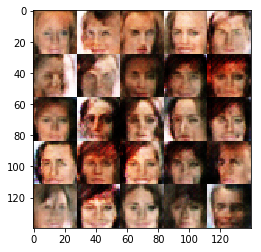

Epoch 2/10 Step 2100... Discriminator Loss: 1.1979... Generator Loss: 0.7614 ... Time spent=0.1751
Epoch 2/10 Step 2200... Discriminator Loss: 1.2171... Generator Loss: 0.8449 ... Time spent=0.1748


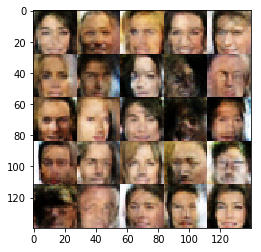

Epoch 2/10 Step 2300... Discriminator Loss: 1.2064... Generator Loss: 0.8020 ... Time spent=0.1752
Epoch 2/10 Step 2400... Discriminator Loss: 1.1100... Generator Loss: 0.9802 ... Time spent=0.1754


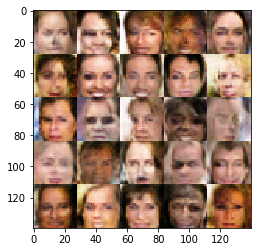

Epoch 2/10 Step 2500... Discriminator Loss: 1.1899... Generator Loss: 1.0292 ... Time spent=0.1739
Epoch 2/10 Step 2600... Discriminator Loss: 1.2941... Generator Loss: 1.5485 ... Time spent=0.1760


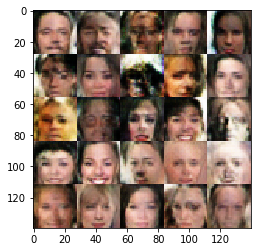

Epoch 2/10 Step 2700... Discriminator Loss: 1.1606... Generator Loss: 1.3053 ... Time spent=0.1756
Epoch 2/10 Step 2800... Discriminator Loss: 1.3513... Generator Loss: 1.2519 ... Time spent=0.1766


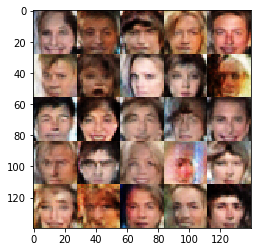

Epoch 2/10 Step 2900... Discriminator Loss: 1.2393... Generator Loss: 0.7442 ... Time spent=0.1752
Epoch 2/10 Step 3000... Discriminator Loss: 1.2089... Generator Loss: 0.8365 ... Time spent=0.1772


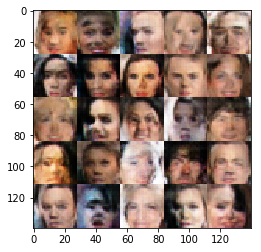

Epoch 2/10 Step 3100... Discriminator Loss: 1.1047... Generator Loss: 0.9462 ... Time spent=0.1754
Epoch 2/10 Step 3200... Discriminator Loss: 1.0984... Generator Loss: 1.6413 ... Time spent=0.1755


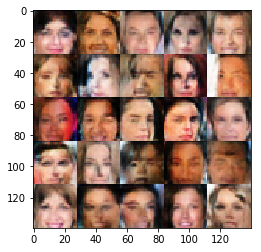

Epoch 2/10 Step 3300... Discriminator Loss: 1.2651... Generator Loss: 0.8672 ... Time spent=0.1751
Epoch 2/10 Step 3400... Discriminator Loss: 1.3500... Generator Loss: 0.5831 ... Time spent=0.1772


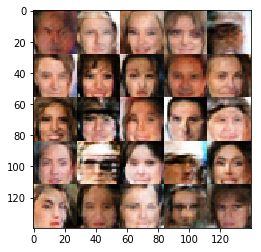

Epoch 2/10 Step 3500... Discriminator Loss: 1.2349... Generator Loss: 0.8574 ... Time spent=0.1741
Epoch 2/10 Step 3600... Discriminator Loss: 1.2852... Generator Loss: 0.6928 ... Time spent=0.1741


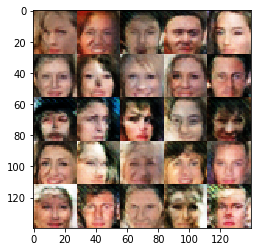

Epoch 2/10 Step 3700... Discriminator Loss: 1.3322... Generator Loss: 0.7884 ... Time spent=0.1759
Epoch 2/10 Step 3800... Discriminator Loss: 1.2045... Generator Loss: 0.9179 ... Time spent=0.1758


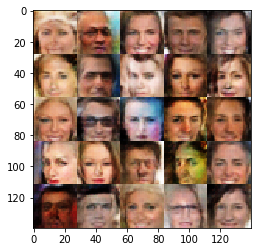

Epoch 2/10 Step 3900... Discriminator Loss: 1.5040... Generator Loss: 1.6938 ... Time spent=0.1740
Epoch 2/10 Step 4000... Discriminator Loss: 1.4873... Generator Loss: 0.4730 ... Time spent=0.1746


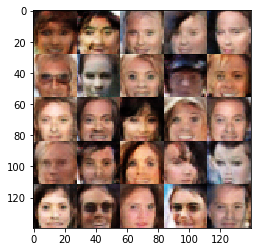

Epoch 3/10 Step 4100... Discriminator Loss: 1.2184... Generator Loss: 0.9422 ... Time spent=0.1747
Epoch 3/10 Step 4200... Discriminator Loss: 1.2355... Generator Loss: 0.9706 ... Time spent=0.1740


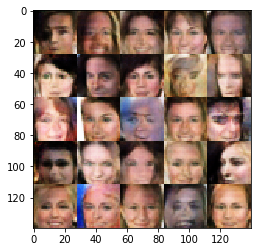

Epoch 3/10 Step 4300... Discriminator Loss: 1.2263... Generator Loss: 1.0910 ... Time spent=0.1746
Epoch 3/10 Step 4400... Discriminator Loss: 1.2349... Generator Loss: 0.8391 ... Time spent=0.1755


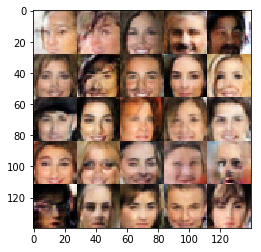

Epoch 3/10 Step 4500... Discriminator Loss: 1.1473... Generator Loss: 0.8838 ... Time spent=0.1746
Epoch 3/10 Step 4600... Discriminator Loss: 1.3364... Generator Loss: 0.6251 ... Time spent=0.1741


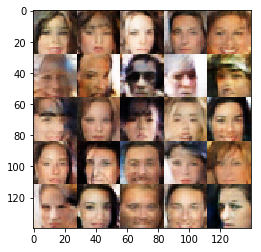

Epoch 3/10 Step 4700... Discriminator Loss: 1.2202... Generator Loss: 0.9983 ... Time spent=0.1745
Epoch 3/10 Step 4800... Discriminator Loss: 1.3541... Generator Loss: 0.7746 ... Time spent=0.1756


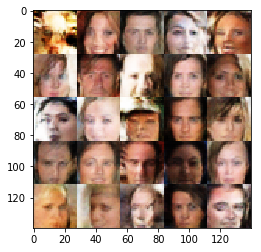

Epoch 3/10 Step 4900... Discriminator Loss: 1.2169... Generator Loss: 0.8996 ... Time spent=0.1746
Epoch 3/10 Step 5000... Discriminator Loss: 1.1519... Generator Loss: 0.9357 ... Time spent=0.1761


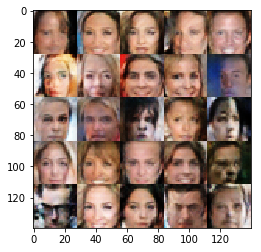

Epoch 3/10 Step 5100... Discriminator Loss: 1.5058... Generator Loss: 0.4609 ... Time spent=0.1749
Epoch 3/10 Step 5200... Discriminator Loss: 1.1407... Generator Loss: 0.9591 ... Time spent=0.1740


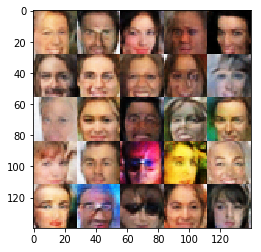

Epoch 3/10 Step 5300... Discriminator Loss: 1.2354... Generator Loss: 0.9677 ... Time spent=0.1740
Epoch 3/10 Step 5400... Discriminator Loss: 1.2107... Generator Loss: 0.7647 ... Time spent=0.1756


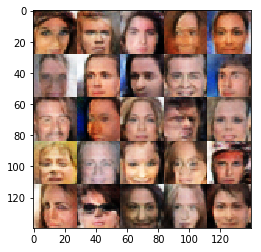

Epoch 3/10 Step 5500... Discriminator Loss: 1.4561... Generator Loss: 1.2622 ... Time spent=0.1741
Epoch 3/10 Step 5600... Discriminator Loss: 1.2617... Generator Loss: 0.9024 ... Time spent=0.1758


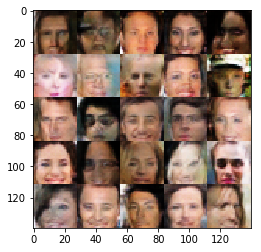

Epoch 3/10 Step 5700... Discriminator Loss: 1.3428... Generator Loss: 1.4413 ... Time spent=0.1758
Epoch 3/10 Step 5800... Discriminator Loss: 1.2565... Generator Loss: 0.9107 ... Time spent=0.1766


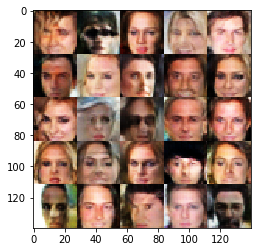

Epoch 3/10 Step 5900... Discriminator Loss: 1.2702... Generator Loss: 0.8262 ... Time spent=0.1734
Epoch 3/10 Step 6000... Discriminator Loss: 1.3320... Generator Loss: 0.7053 ... Time spent=0.1751


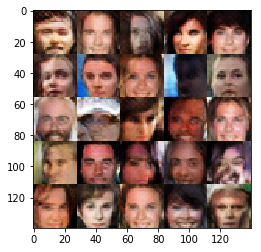

Epoch 4/10 Step 6100... Discriminator Loss: 1.3856... Generator Loss: 0.6314 ... Time spent=0.1745
Epoch 4/10 Step 6200... Discriminator Loss: 1.2308... Generator Loss: 0.7198 ... Time spent=0.1749


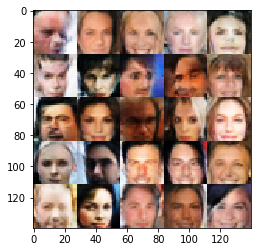

Epoch 4/10 Step 6300... Discriminator Loss: 1.1927... Generator Loss: 1.0661 ... Time spent=0.1752
Epoch 4/10 Step 6400... Discriminator Loss: 1.3996... Generator Loss: 0.6966 ... Time spent=0.1746


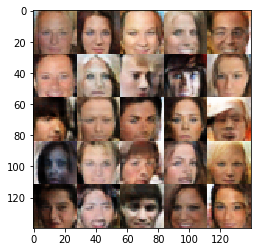

Epoch 4/10 Step 6500... Discriminator Loss: 1.3420... Generator Loss: 1.0733 ... Time spent=0.1758
Epoch 4/10 Step 6600... Discriminator Loss: 1.1839... Generator Loss: 0.9773 ... Time spent=0.1748


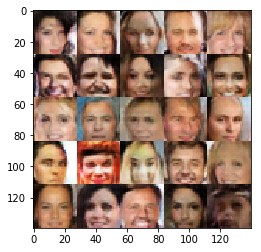

Epoch 4/10 Step 6700... Discriminator Loss: 1.5618... Generator Loss: 1.1671 ... Time spent=0.1754
Epoch 4/10 Step 6800... Discriminator Loss: 1.1993... Generator Loss: 0.7267 ... Time spent=0.1749


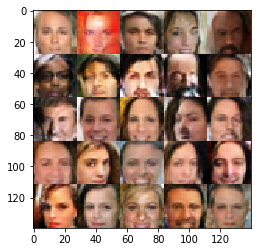

Epoch 4/10 Step 6900... Discriminator Loss: 1.2536... Generator Loss: 0.7060 ... Time spent=0.1759
Epoch 4/10 Step 7000... Discriminator Loss: 1.4260... Generator Loss: 0.8226 ... Time spent=0.1751


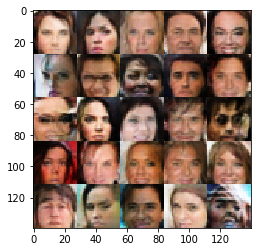

Epoch 4/10 Step 7100... Discriminator Loss: 1.3723... Generator Loss: 0.5717 ... Time spent=0.1753
Epoch 4/10 Step 7200... Discriminator Loss: 1.1986... Generator Loss: 1.0202 ... Time spent=0.1752


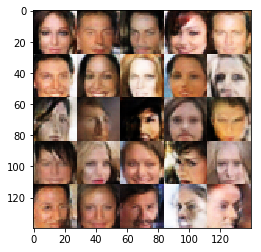

Epoch 4/10 Step 7300... Discriminator Loss: 1.4031... Generator Loss: 0.7373 ... Time spent=0.1756
Epoch 4/10 Step 7400... Discriminator Loss: 1.2562... Generator Loss: 0.8836 ... Time spent=0.1749


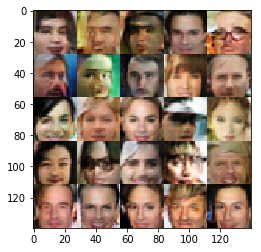

Epoch 4/10 Step 7500... Discriminator Loss: 1.0421... Generator Loss: 0.9612 ... Time spent=0.1740
Epoch 4/10 Step 7600... Discriminator Loss: 1.2232... Generator Loss: 0.6596 ... Time spent=0.1740


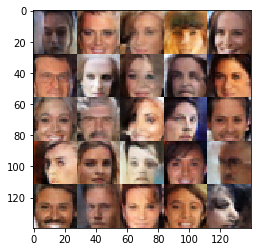

Epoch 4/10 Step 7700... Discriminator Loss: 1.2039... Generator Loss: 0.8739 ... Time spent=0.1760
Epoch 4/10 Step 7800... Discriminator Loss: 1.3300... Generator Loss: 0.5607 ... Time spent=0.1749


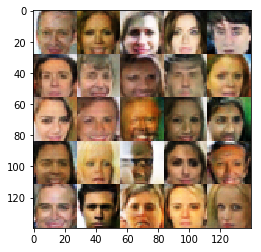

Epoch 4/10 Step 7900... Discriminator Loss: 1.2730... Generator Loss: 0.7726 ... Time spent=0.1746
Epoch 4/10 Step 8000... Discriminator Loss: 0.9896... Generator Loss: 1.0088 ... Time spent=0.1752


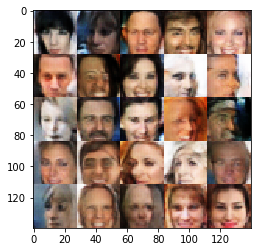

Epoch 4/10 Step 8100... Discriminator Loss: 1.2246... Generator Loss: 0.7493 ... Time spent=0.1747
Epoch 5/10 Step 8200... Discriminator Loss: 1.5003... Generator Loss: 0.4901 ... Time spent=0.1759


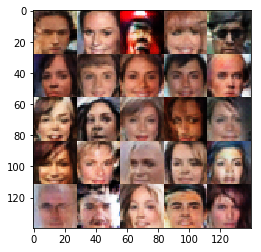

Epoch 5/10 Step 8300... Discriminator Loss: 1.4683... Generator Loss: 0.5327 ... Time spent=0.1747
Epoch 5/10 Step 8400... Discriminator Loss: 1.2633... Generator Loss: 0.7019 ... Time spent=0.1742


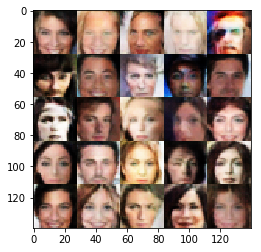

Epoch 5/10 Step 8500... Discriminator Loss: 1.4215... Generator Loss: 0.5097 ... Time spent=0.1746
Epoch 5/10 Step 8600... Discriminator Loss: 1.4941... Generator Loss: 0.4686 ... Time spent=0.1743


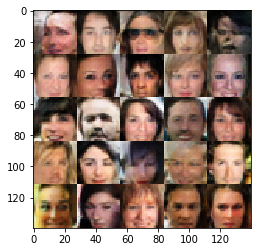

Epoch 5/10 Step 8700... Discriminator Loss: 1.3348... Generator Loss: 0.9490 ... Time spent=0.1758
Epoch 5/10 Step 8800... Discriminator Loss: 1.1354... Generator Loss: 0.7832 ... Time spent=0.1761


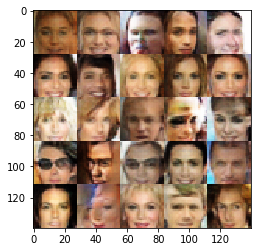

Epoch 5/10 Step 8900... Discriminator Loss: 1.2168... Generator Loss: 0.7589 ... Time spent=0.1746
Epoch 5/10 Step 9000... Discriminator Loss: 1.4512... Generator Loss: 0.5156 ... Time spent=0.1745


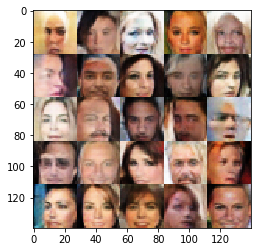

Epoch 5/10 Step 9100... Discriminator Loss: 1.2743... Generator Loss: 0.7015 ... Time spent=0.1752
Epoch 5/10 Step 9200... Discriminator Loss: 1.3379... Generator Loss: 0.7185 ... Time spent=0.1734


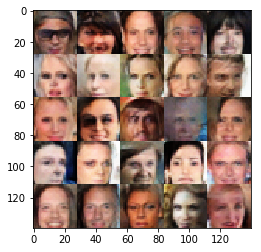

Epoch 5/10 Step 9300... Discriminator Loss: 1.1644... Generator Loss: 0.8584 ... Time spent=0.1738
Epoch 5/10 Step 9400... Discriminator Loss: 1.1048... Generator Loss: 1.1262 ... Time spent=0.1753


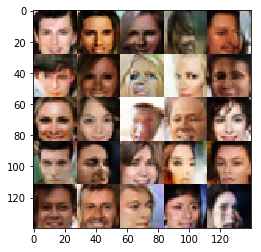

Epoch 5/10 Step 9500... Discriminator Loss: 1.2110... Generator Loss: 1.3287 ... Time spent=0.1742
Epoch 5/10 Step 9600... Discriminator Loss: 1.2640... Generator Loss: 0.6469 ... Time spent=0.1767


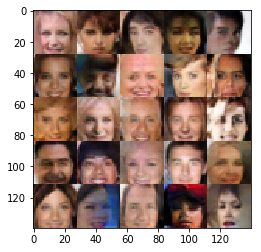

Epoch 5/10 Step 9700... Discriminator Loss: 1.2066... Generator Loss: 1.1164 ... Time spent=0.1768
Epoch 5/10 Step 9800... Discriminator Loss: 1.4867... Generator Loss: 0.4865 ... Time spent=0.1746


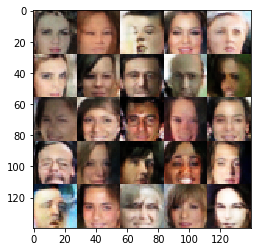

Epoch 5/10 Step 9900... Discriminator Loss: 1.0186... Generator Loss: 1.1031 ... Time spent=0.1743
Epoch 5/10 Step 10000... Discriminator Loss: 1.2060... Generator Loss: 1.1092 ... Time spent=0.1745


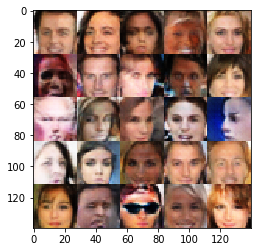

Epoch 5/10 Step 10100... Discriminator Loss: 1.4751... Generator Loss: 0.4909 ... Time spent=0.1739
Epoch 6/10 Step 10200... Discriminator Loss: 1.2053... Generator Loss: 0.9098 ... Time spent=0.1745


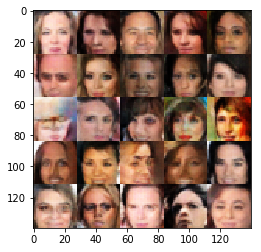

Epoch 6/10 Step 10300... Discriminator Loss: 1.2898... Generator Loss: 0.6163 ... Time spent=0.1751
Epoch 6/10 Step 10400... Discriminator Loss: 1.2532... Generator Loss: 1.2552 ... Time spent=0.1753


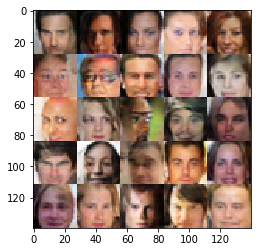

Epoch 6/10 Step 10500... Discriminator Loss: 0.9833... Generator Loss: 1.2448 ... Time spent=0.1744
Epoch 6/10 Step 10600... Discriminator Loss: 1.2875... Generator Loss: 1.0175 ... Time spent=0.1752


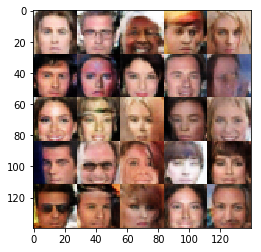

Epoch 6/10 Step 10700... Discriminator Loss: 1.2095... Generator Loss: 1.2138 ... Time spent=0.1762
Epoch 6/10 Step 10800... Discriminator Loss: 1.3483... Generator Loss: 0.5935 ... Time spent=0.1752


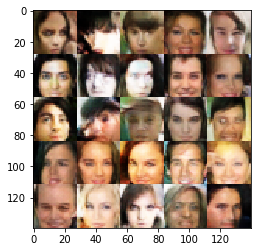

Epoch 6/10 Step 10900... Discriminator Loss: 1.1946... Generator Loss: 1.0816 ... Time spent=0.1751
Epoch 6/10 Step 11000... Discriminator Loss: 1.2126... Generator Loss: 0.7124 ... Time spent=0.1752


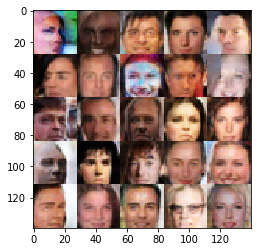

Epoch 6/10 Step 11100... Discriminator Loss: 1.0778... Generator Loss: 0.8792 ... Time spent=0.1747
Epoch 6/10 Step 11200... Discriminator Loss: 1.1729... Generator Loss: 0.7403 ... Time spent=0.1743


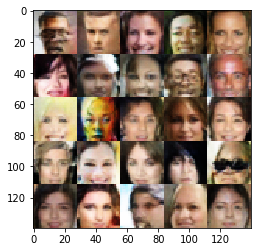

Epoch 6/10 Step 11300... Discriminator Loss: 1.1078... Generator Loss: 0.8878 ... Time spent=0.1746
Epoch 6/10 Step 11400... Discriminator Loss: 1.1679... Generator Loss: 0.7611 ... Time spent=0.1741


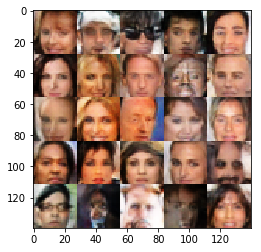

Epoch 6/10 Step 11500... Discriminator Loss: 1.2514... Generator Loss: 1.1344 ... Time spent=0.1753
Epoch 6/10 Step 11600... Discriminator Loss: 1.4580... Generator Loss: 0.8832 ... Time spent=0.1756


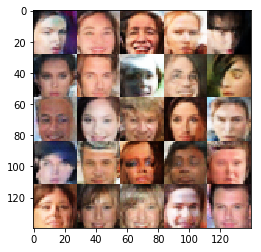

Epoch 6/10 Step 11700... Discriminator Loss: 1.0968... Generator Loss: 0.8714 ... Time spent=0.1744
Epoch 6/10 Step 11800... Discriminator Loss: 1.0287... Generator Loss: 1.0353 ... Time spent=0.1744


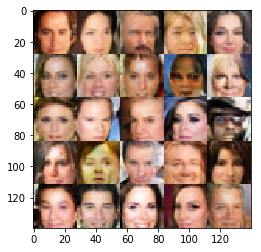

Epoch 6/10 Step 11900... Discriminator Loss: 0.9202... Generator Loss: 1.1039 ... Time spent=0.1746
Epoch 6/10 Step 12000... Discriminator Loss: 1.1592... Generator Loss: 0.9280 ... Time spent=0.1748


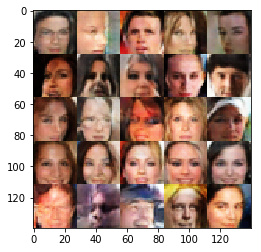

Epoch 6/10 Step 12100... Discriminator Loss: 1.3227... Generator Loss: 1.2169 ... Time spent=0.1732
Epoch 7/10 Step 12200... Discriminator Loss: 1.2433... Generator Loss: 1.0495 ... Time spent=0.1750


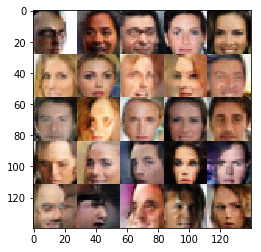

Epoch 7/10 Step 12300... Discriminator Loss: 1.0059... Generator Loss: 1.2420 ... Time spent=0.1755
Epoch 7/10 Step 12400... Discriminator Loss: 1.2381... Generator Loss: 1.1250 ... Time spent=0.1747


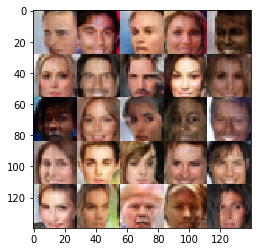

Epoch 7/10 Step 12500... Discriminator Loss: 1.2584... Generator Loss: 1.0508 ... Time spent=0.1759
Epoch 7/10 Step 12600... Discriminator Loss: 0.9975... Generator Loss: 0.8428 ... Time spent=0.1759


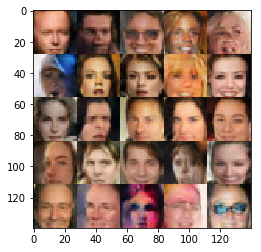

Epoch 7/10 Step 12700... Discriminator Loss: 1.1520... Generator Loss: 0.7928 ... Time spent=0.1743
Epoch 7/10 Step 12800... Discriminator Loss: 0.9209... Generator Loss: 1.2721 ... Time spent=0.1745


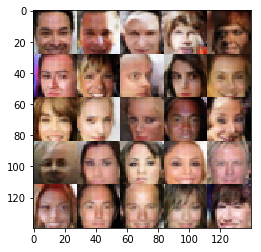

Epoch 7/10 Step 12900... Discriminator Loss: 1.2138... Generator Loss: 0.6860 ... Time spent=0.1734
Epoch 7/10 Step 13000... Discriminator Loss: 1.2752... Generator Loss: 0.6557 ... Time spent=0.1749


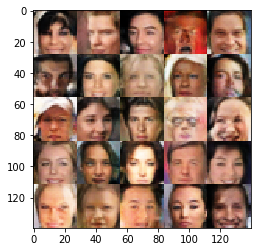

Epoch 7/10 Step 13100... Discriminator Loss: 1.1932... Generator Loss: 0.7108 ... Time spent=0.1756
Epoch 7/10 Step 13200... Discriminator Loss: 1.5643... Generator Loss: 0.4098 ... Time spent=0.1751


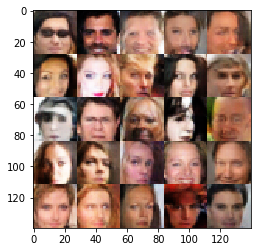

Epoch 7/10 Step 13300... Discriminator Loss: 1.1557... Generator Loss: 0.7576 ... Time spent=0.1761
Epoch 7/10 Step 13400... Discriminator Loss: 1.2956... Generator Loss: 0.7975 ... Time spent=0.1752


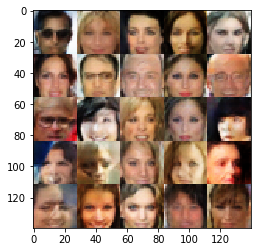

Epoch 7/10 Step 13500... Discriminator Loss: 1.2386... Generator Loss: 0.8884 ... Time spent=0.1749
Epoch 7/10 Step 13600... Discriminator Loss: 0.9910... Generator Loss: 1.2401 ... Time spent=0.1743


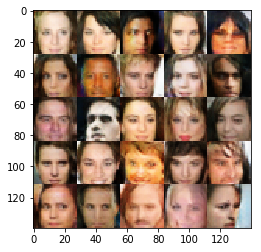

Epoch 7/10 Step 13700... Discriminator Loss: 1.2716... Generator Loss: 1.5905 ... Time spent=0.1746
Epoch 7/10 Step 13800... Discriminator Loss: 0.9126... Generator Loss: 1.2436 ... Time spent=0.1755


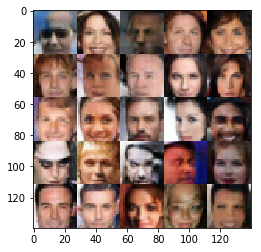

Epoch 7/10 Step 13900... Discriminator Loss: 0.9615... Generator Loss: 0.9948 ... Time spent=0.1764
Epoch 7/10 Step 14000... Discriminator Loss: 1.1553... Generator Loss: 0.7250 ... Time spent=0.1746


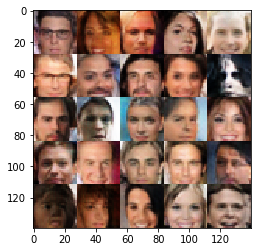

Epoch 7/10 Step 14100... Discriminator Loss: 1.4831... Generator Loss: 0.4553 ... Time spent=0.1761
Epoch 8/10 Step 14200... Discriminator Loss: 1.4550... Generator Loss: 0.5875 ... Time spent=0.1760


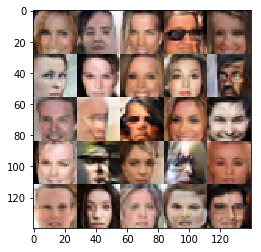

Epoch 8/10 Step 14300... Discriminator Loss: 1.5073... Generator Loss: 0.4352 ... Time spent=0.1763
Epoch 8/10 Step 14400... Discriminator Loss: 0.9844... Generator Loss: 1.0227 ... Time spent=0.1758


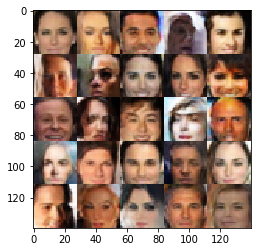

Epoch 8/10 Step 14500... Discriminator Loss: 1.1589... Generator Loss: 0.8228 ... Time spent=0.1755
Epoch 8/10 Step 14600... Discriminator Loss: 1.2020... Generator Loss: 1.2881 ... Time spent=0.1748


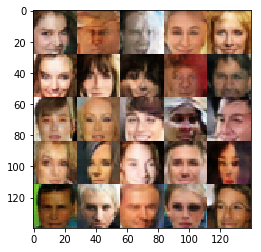

Epoch 8/10 Step 14700... Discriminator Loss: 1.3585... Generator Loss: 0.5183 ... Time spent=0.1760
Epoch 8/10 Step 14800... Discriminator Loss: 1.0253... Generator Loss: 1.2221 ... Time spent=0.1750


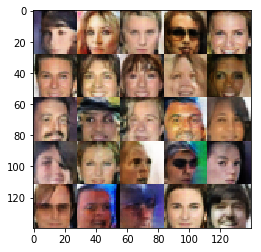

Epoch 8/10 Step 14900... Discriminator Loss: 1.0307... Generator Loss: 1.0807 ... Time spent=0.1739
Epoch 8/10 Step 15000... Discriminator Loss: 1.2424... Generator Loss: 0.6332 ... Time spent=0.1740


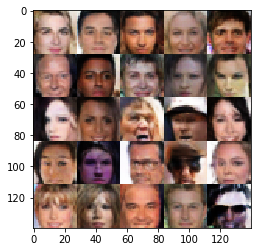

Epoch 8/10 Step 15100... Discriminator Loss: 1.4226... Generator Loss: 1.2634 ... Time spent=0.1752
Epoch 8/10 Step 15200... Discriminator Loss: 1.3094... Generator Loss: 0.6208 ... Time spent=0.1754


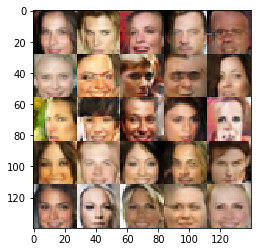

Epoch 8/10 Step 15300... Discriminator Loss: 1.2111... Generator Loss: 2.2317 ... Time spent=0.1750
Epoch 8/10 Step 15400... Discriminator Loss: 1.1328... Generator Loss: 0.7442 ... Time spent=0.1743


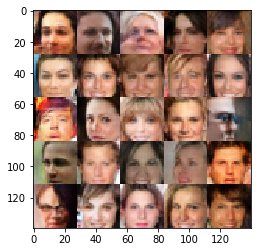

Epoch 8/10 Step 15500... Discriminator Loss: 1.2395... Generator Loss: 1.5032 ... Time spent=0.1755
Epoch 8/10 Step 15600... Discriminator Loss: 1.0711... Generator Loss: 0.7932 ... Time spent=0.1744


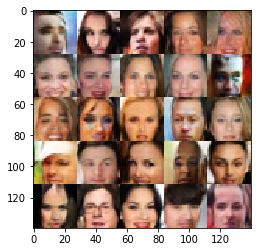

Epoch 8/10 Step 15700... Discriminator Loss: 0.9337... Generator Loss: 1.5531 ... Time spent=0.1752
Epoch 8/10 Step 15800... Discriminator Loss: 1.1150... Generator Loss: 1.1576 ... Time spent=0.1746


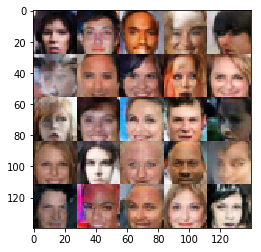

Epoch 8/10 Step 15900... Discriminator Loss: 1.5882... Generator Loss: 0.3976 ... Time spent=0.1758
Epoch 8/10 Step 16000... Discriminator Loss: 1.2027... Generator Loss: 0.7361 ... Time spent=0.1748


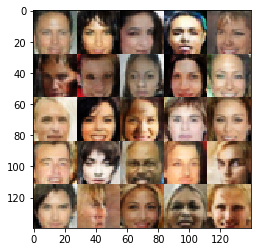

Epoch 8/10 Step 16100... Discriminator Loss: 1.3317... Generator Loss: 0.5635 ... Time spent=0.1747
Epoch 8/10 Step 16200... Discriminator Loss: 1.6089... Generator Loss: 0.3985 ... Time spent=0.1749


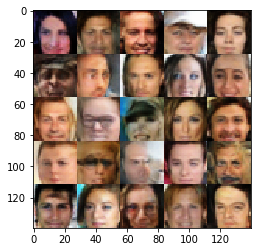

Epoch 9/10 Step 16300... Discriminator Loss: 1.5247... Generator Loss: 0.4637 ... Time spent=0.1757
Epoch 9/10 Step 16400... Discriminator Loss: 1.1741... Generator Loss: 1.1553 ... Time spent=0.1733


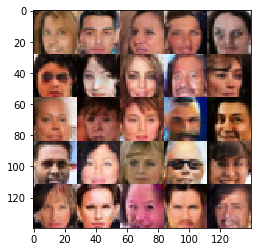

Epoch 9/10 Step 16500... Discriminator Loss: 1.0806... Generator Loss: 0.9175 ... Time spent=0.1758
Epoch 9/10 Step 16600... Discriminator Loss: 1.0490... Generator Loss: 0.8199 ... Time spent=0.1745


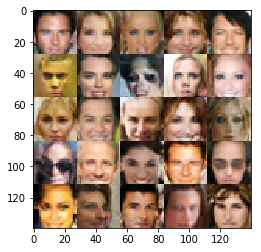

Epoch 9/10 Step 16700... Discriminator Loss: 0.8084... Generator Loss: 1.5989 ... Time spent=0.1757
Epoch 9/10 Step 16800... Discriminator Loss: 1.1288... Generator Loss: 0.7283 ... Time spent=0.1745


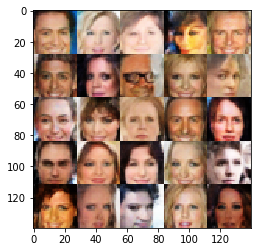

Epoch 9/10 Step 16900... Discriminator Loss: 1.2113... Generator Loss: 0.6849 ... Time spent=0.1750
Epoch 9/10 Step 17000... Discriminator Loss: 1.4544... Generator Loss: 0.5022 ... Time spent=0.1744


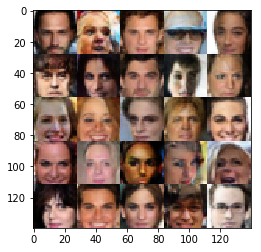

Epoch 9/10 Step 17100... Discriminator Loss: 1.3335... Generator Loss: 0.5679 ... Time spent=0.1743
Epoch 9/10 Step 17200... Discriminator Loss: 0.9700... Generator Loss: 1.3839 ... Time spent=0.1753


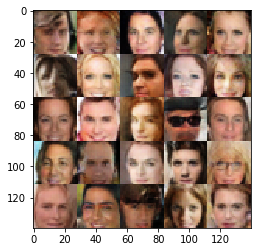

Epoch 9/10 Step 17300... Discriminator Loss: 1.0738... Generator Loss: 0.8525 ... Time spent=0.1756
Epoch 9/10 Step 17400... Discriminator Loss: 1.1621... Generator Loss: 0.8768 ... Time spent=0.1750


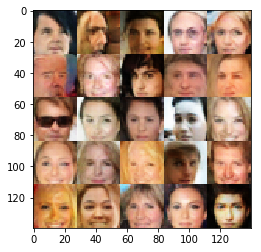

Epoch 9/10 Step 17500... Discriminator Loss: 0.9271... Generator Loss: 1.1609 ... Time spent=0.1748
Epoch 9/10 Step 17600... Discriminator Loss: 0.9970... Generator Loss: 1.0757 ... Time spent=0.1756


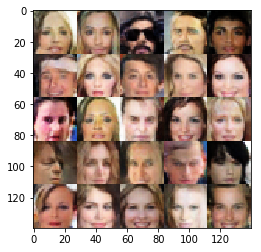

Epoch 9/10 Step 17700... Discriminator Loss: 1.3414... Generator Loss: 0.5420 ... Time spent=0.1739
Epoch 9/10 Step 17800... Discriminator Loss: 1.2841... Generator Loss: 1.7182 ... Time spent=0.1750


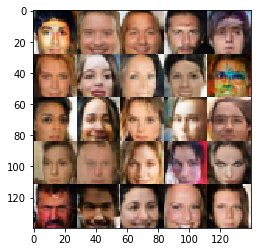

Epoch 9/10 Step 17900... Discriminator Loss: 1.0051... Generator Loss: 1.1907 ... Time spent=0.1747
Epoch 9/10 Step 18000... Discriminator Loss: 1.0746... Generator Loss: 1.8509 ... Time spent=0.1756


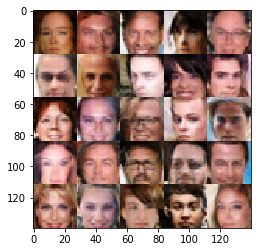

Epoch 9/10 Step 18100... Discriminator Loss: 0.8431... Generator Loss: 1.3799 ... Time spent=0.1758
Epoch 9/10 Step 18200... Discriminator Loss: 1.8752... Generator Loss: 0.3138 ... Time spent=0.1751


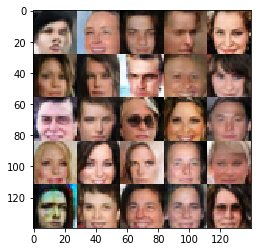

Epoch 10/10 Step 18300... Discriminator Loss: 0.9935... Generator Loss: 1.1103 ... Time spent=0.1752
Epoch 10/10 Step 18400... Discriminator Loss: 0.9369... Generator Loss: 1.8092 ... Time spent=0.1749


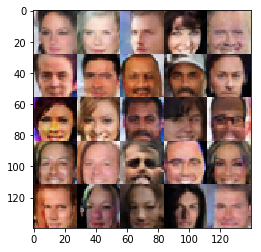

Epoch 10/10 Step 18500... Discriminator Loss: 0.8374... Generator Loss: 1.4624 ... Time spent=0.1748
Epoch 10/10 Step 18600... Discriminator Loss: 0.8559... Generator Loss: 1.9090 ... Time spent=0.1747


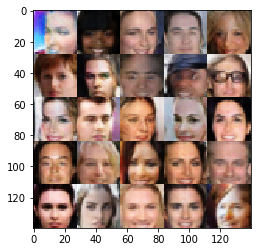

Epoch 10/10 Step 18700... Discriminator Loss: 1.4639... Generator Loss: 1.0520 ... Time spent=0.1746
Epoch 10/10 Step 18800... Discriminator Loss: 1.5236... Generator Loss: 0.4499 ... Time spent=0.1752


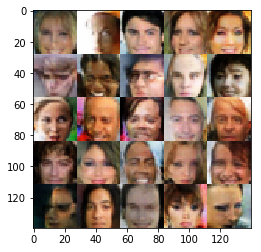

Epoch 10/10 Step 18900... Discriminator Loss: 1.1367... Generator Loss: 0.8436 ... Time spent=0.1746
Epoch 10/10 Step 19000... Discriminator Loss: 1.3510... Generator Loss: 1.3806 ... Time spent=0.1757


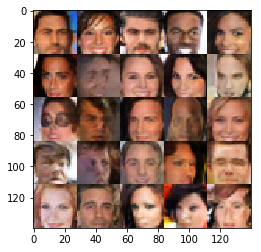

Epoch 10/10 Step 19100... Discriminator Loss: 1.1159... Generator Loss: 0.7373 ... Time spent=0.1739
Epoch 10/10 Step 19200... Discriminator Loss: 1.1359... Generator Loss: 0.8487 ... Time spent=0.1755


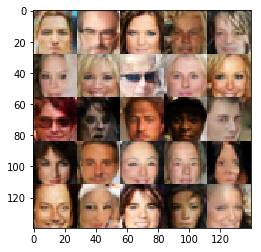

Epoch 10/10 Step 19300... Discriminator Loss: 0.6499... Generator Loss: 1.9585 ... Time spent=0.1750
Epoch 10/10 Step 19400... Discriminator Loss: 0.8747... Generator Loss: 1.4410 ... Time spent=0.1752


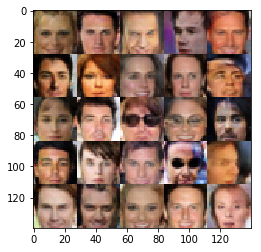

Epoch 10/10 Step 19500... Discriminator Loss: 0.9734... Generator Loss: 0.9144 ... Time spent=0.1751
Epoch 10/10 Step 19600... Discriminator Loss: 0.8655... Generator Loss: 1.1669 ... Time spent=0.1743


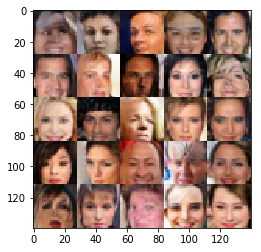

Epoch 10/10 Step 19700... Discriminator Loss: 0.9062... Generator Loss: 2.5924 ... Time spent=0.1756
Epoch 10/10 Step 19800... Discriminator Loss: 1.0132... Generator Loss: 1.0453 ... Time spent=0.1758


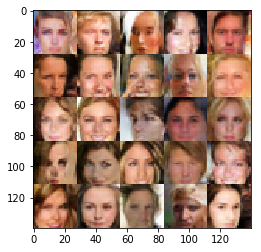

Epoch 10/10 Step 19900... Discriminator Loss: 1.1494... Generator Loss: 0.7636 ... Time spent=0.1754
Epoch 10/10 Step 20000... Discriminator Loss: 1.5184... Generator Loss: 0.4838 ... Time spent=0.1731


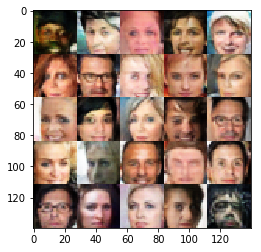

Epoch 10/10 Step 20100... Discriminator Loss: 0.9184... Generator Loss: 0.9807 ... Time spent=0.1754
Epoch 10/10 Step 20200... Discriminator Loss: 0.8456... Generator Loss: 1.3756 ... Time spent=0.1752


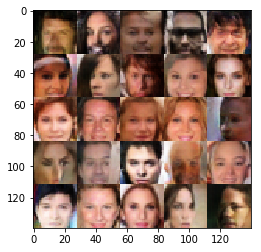

In [29]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.